# Project description
We are interested in what sentiment our models predict on the speaker and the listener in the dialogue.

We will collapse our 32 emotion types into three categories 'positive', 'negative', and 'neutral'. 
A training example is the emotion type e.g. 'anxious' , 'terrified' , 'angry' and a prompt e.g. 'One time I had to take a trip away from home for three weeks_comma_ it made me very nervous.' 


The following are different techniques to collapse the emotions
* Technique one: Manually. For each emotion, we determine its category using a majority opinion. 
* Technique two: Spacy similiarity function. The function can be trained on any word vector dataset. We are currently using word2vec
* Technique three: Vader. I am not really sure how this works

We are also interested in the relationship the emotions have with each other. For example, using the spacy similiarity function, we found that nostalgic is similar to sad and sentimental and it is possible to do word vector arthmetic so nostalgic = sad + sentimental. So a natural question is does the sentiment of a dialogue which is labeled nostalgic behave similarly. Meaning the speaker will say sad and sentimental things. 


# Model Pipeline

Note: When working on implementing a part, please make a copy of the notebook and work on it locally to avoid any bugs that may pop up later on down the road. 


In [1]:
from tqdm.auto import tqdm
import os
import pandas as pd
import csv
import pickle as pkl

In [2]:
#Downloads word vectors
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [3]:
!wget https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
!tar xvf empatheticdialogues.tar.gz

--2020-12-12 05:31:18--  https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28022709 (27M) [application/gzip]
Saving to: ‘empatheticdialogues.tar.gz.1’

empatheticdialogues 100%[===================>]  26.72M  16.3MB/s    in 1.6s    

2020-12-12 05:31:20 (16.3 MB/s) - ‘empatheticdialogues.tar.gz.1’ saved [28022709/28022709]

empatheticdialogues/
empatheticdialogues/test.csv
empatheticdialogues/train.csv
empatheticdialogues/valid.csv


In [4]:
!cat empatheticdialogues/train.csv

Streaming output truncated to the last 5000 lines.
hit:505_conv:1011,4,joyful,I happened to have all the ingredients in my fridge to make my favorite sandwich.,139,I tend to pile my sandwich as high as I can and still fit it in my mouth. I am like the Scooby Doo of sandwich doctors.,5|4|4_5|5|5,
hit:508_conv:1016,1,guilty,I was on one of my social media sites and ignored a message from one of my friends who said she really needed someone to go with her to an appointment for her mom so she didn't have to sit by herself in waiting room while her mom was in the back talking with doctor. Come to find out her mom had cancer and my friend just wanted me there for support.,91,Ignored my friends message on one of my social media sites that just wanted support from me after finding out her mom had cancer. ,4|4|5_5|5|5,
hit:508_conv:1016,2,guilty,I was on one of my social media sites and ignored a message from one of my friends who said she really needed someone to go with her to an appointment 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



mma_ a friend of mine who works for me was offered another job.  He is so vital to our team in our business.  I really did not want him to leave the company.  In the end_comma_ he was faithful to our company.  I am thankful for such a good friend.,485,A friend of mine who works for me (really with me) was recently offered another job for a little more pay.  I was quite nervous on what he would decide.  In fact_comma_ he never even mentioned it to me.  I found out through an acquaintance that he had been offered the job.,5|5|5_5|5|5,
hit:12341_conv:24682,2,faithful,Recently_comma_ a friend of mine who works for me was offered another job.  He is so vital to our team in our business.  I really did not want him to leave the company.  In the end_comma_ he was faithful to our company.  I am thankful for such a good friend.,59,I hope you don't feel jealous of your friend. Did he accept the job?,5|5|5_5|5|5,
hit:12341_conv:24682,3,faithful,Recently_comma_ a friend of mine who works for me was

In [5]:
def prepare_dataset(target_file):
  dataset_dir = os.path.join(os.getcwd(),'empatheticdialogues')

  examples = {}
  
  for file in tqdm(os.listdir(dataset_dir)):
    if file == target_file + '.csv':
      file_path = os.path.join(dataset_dir,file)
      return pd.read_csv(file_path,error_bad_lines=False)
    

In [6]:
df = prepare_dataset('train')

b'Skipping line 2355: expected 8 fields, saw 10\nSkipping line 36628: expected 8 fields, saw 12\nSkipping line 49433: expected 8 fields, saw 10\nSkipping line 56957: expected 8 fields, saw 10\nSkipping line 65019: expected 8 fields, saw 10\n'


In [7]:
negative_emotions = ['afraid','angry','annoyed','anxious','apprehensive','ashamed','devastated','disappointed','disgusted','embarrassed','furious','guilty','jealous','lonely','sad','terrified']
neutral_emotions = ['anticipating','faithful','hopeful','nostalgic','prepared','trusting']
positive_emotions = ['caring','confident','content','excited','grateful','impressed','joyful','proud','sentimental','surprised']

In [8]:
def convert_labels_to_strings(labels):
  return ' '.join(labels)

In [9]:
labels = convert_labels_to_strings(positive_emotions + negative_emotions + neutral_emotions)

In [10]:
import en_core_web_lg

nlp = en_core_web_lg.load()
tokens = nlp(labels)

similar_groups = {}
for token1 in tokens:
    for token2 in tokens:
      if token1.similarity(token2) > 0.5 and token1.text != token2.text:
        similar_groups[(token1.text,token2.text)] = token1.similarity(token2)
len(similar_groups),similar_groups

(284,
 {('afraid', 'angry'): 0.6656315,
  ('afraid', 'annoyed'): 0.6348786,
  ('afraid', 'anxious'): 0.68030304,
  ('afraid', 'apprehensive'): 0.61497825,
  ('afraid', 'ashamed'): 0.73413473,
  ('afraid', 'confident'): 0.56039554,
  ('afraid', 'disappointed'): 0.62554854,
  ('afraid', 'disgusted'): 0.56182647,
  ('afraid', 'embarrassed'): 0.67440075,
  ('afraid', 'excited'): 0.51642305,
  ('afraid', 'grateful'): 0.53454614,
  ('afraid', 'jealous'): 0.6207355,
  ('afraid', 'lonely'): 0.52083397,
  ('afraid', 'sad'): 0.6116281,
  ('afraid', 'surprised'): 0.70930153,
  ('afraid', 'terrified'): 0.7373339,
  ('afraid', 'trusting'): 0.5792823,
  ('angry', 'afraid'): 0.6656315,
  ('angry', 'annoyed'): 0.7570387,
  ('angry', 'anxious'): 0.6370114,
  ('angry', 'ashamed'): 0.5821856,
  ('angry', 'disappointed'): 0.5860411,
  ('angry', 'disgusted'): 0.66764253,
  ('angry', 'embarrassed'): 0.6301988,
  ('angry', 'furious'): 0.743952,
  ('angry', 'jealous'): 0.6775863,
  ('angry', 'lonely'): 0.5184

In [ ]:
!pip install whatlies

In [24]:
labels = positive_emotions + negative_emotions + neutral_emotions

In [25]:
from whatlies import EmbeddingSet
from whatlies.language import SpacyLanguage

lang = SpacyLanguage(nlp)
words = labels

emb = lang[words]
emb.plot_interactive()

alt.LayerChart(...)

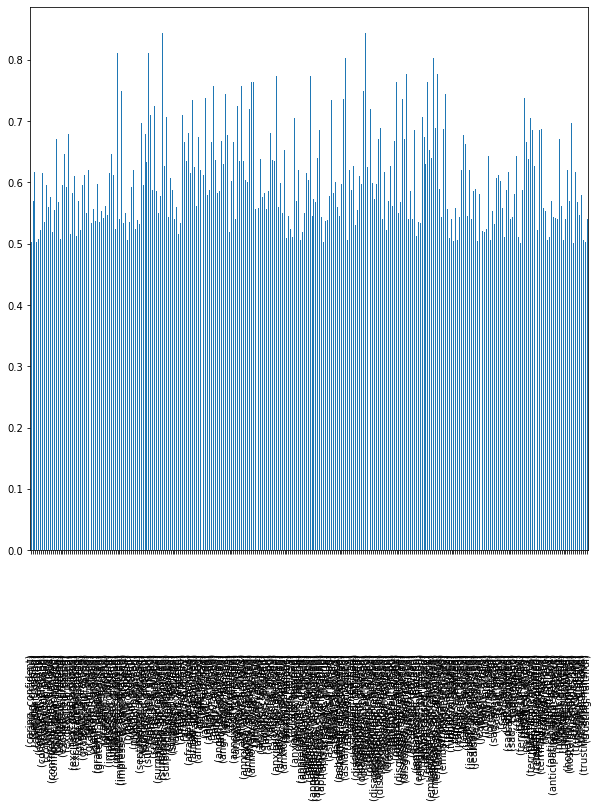

In [23]:
ax = pd.Series(similar_groups).plot(kind='bar',figsize=(10,10))
ax.tick_params(axis='x', which='major', pad=100)

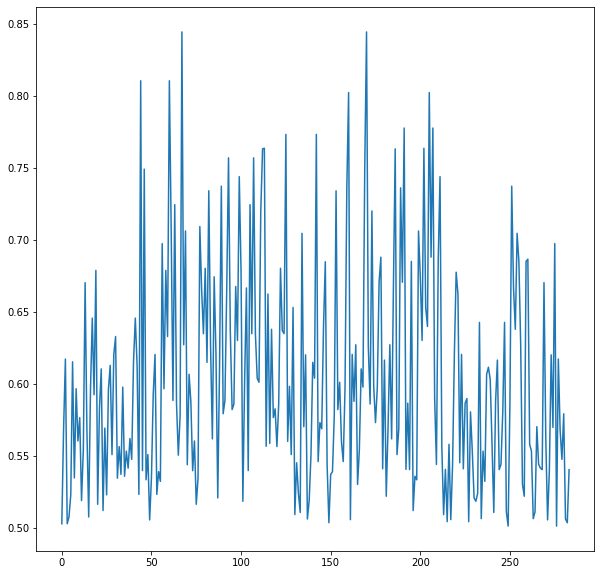

In [28]:
pd.Series(similar_groups.values()).plot(figsize=(10,10))